<a href="https://colab.research.google.com/github/scottspurlock/csc4422-s2025/blob/main/demos/day23_demo_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DMML Day 23 Demo: Word Embedding
We'll train a simple model to predict the next word given a few words of context.

In the process, we'll learn a word embedding: a way to transform individual words into feature vectors that are useful for other tasks.

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab') # pre-trained tokenizer model

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn.functional as F

from sklearn.decomposition import PCA


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [210]:
url = 'https://drive.google.com/uc?export=download&id=1MmVD9CDKSf9EYjjEkCwqEJDyrf1Y_fzq'
df = pd.read_csv(url)
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...
1995,US,"Loaded with scents and flavors of chocolate, m...",Shea Vineyard,88,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Walt
1996,Spain,Aromas of stone fruits and citrus are dusty an...,Vetiver Tempranillo,88,13.0,Northern Spain,Rioja,NaN,Rosado,Bodegas Ontañón
1997,Spain,"Despite being nine years old, this comes acros...",200 Monges Selección Especial Reserva,88,120.0,Northern Spain,Rioja,NaN,Tempranillo Blend,Bodegas Vínícola Real
1998,Italy,"This Barolo has a somewhat raw quality, delive...",Boiolo,88,99.0,Piedmont,Barolo,NaN,Nebbiolo,Camparo


# Data

In [211]:
data = df['description']

# for speed, just use the first few reviews
data = data[:25]

# Tokenize data

In [212]:
# leave stop words in
def tokenize_document(text):
    lower = text.lower()
    # tokens = lower.split()
    tokens = nltk.word_tokenize(lower)
    final = []
    for token in tokens:
        final.append(token)
    return final

def tokenize_corpus(docs):
    tokenized = []
    for doc in docs:
        tokenized_doc = tokenize_document(doc)
        tokenized.append(tokenized_doc)
    return tokenized

tokenized_data = tokenize_corpus(data)

# Build vocabulary

In [213]:
# use a set to remove duplicate tokens
distinct_tokens = set()

for doc in tokenized_data:
    for token in doc:
        distinct_tokens.add(token)

print(f'found {len(distinct_tokens)} distinct tokens')

# convert to list for sorting
distinct_tokens = list(distinct_tokens)
sorted_tokens = sorted(distinct_tokens)
sorted_tokens[:20]

found 554 distinct tokens


['%',
 "'ll",
 "'s",
 ',',
 '.',
 '1,100',
 '100',
 '1200',
 '122',
 '18',
 '18-year-old',
 '1961.',
 '20',
 '2006',
 '2015',
 '2020',
 '2022',
 '2022–2030',
 '2023',
 '2024']

In [214]:
# make dictionary to lookup token id given the token text
word2idx = {}

idx = 0

# add all the tokens
for token in sorted_tokens:
    word2idx[token] = idx
    idx += 1

word2idx

{'%': 0,
 "'ll": 1,
 "'s": 2,
 ',': 3,
 '.': 4,
 '1,100': 5,
 '100': 6,
 '1200': 7,
 '122': 8,
 '18': 9,
 '18-year-old': 10,
 '1961.': 11,
 '20': 12,
 '2006': 13,
 '2015': 14,
 '2020': 15,
 '2022': 16,
 '2022–2030': 17,
 '2023': 18,
 '2024': 19,
 '2028': 20,
 '2030': 21,
 '2032': 22,
 '2035': 23,
 '28': 24,
 '30': 25,
 '5': 26,
 ':': 27,
 'a': 28,
 'abetina': 29,
 'about': 30,
 'accents': 31,
 'acid': 32,
 'acid-driven': 33,
 'acidity': 34,
 'adam': 35,
 'adorn': 36,
 'after': 37,
 'aged': 38,
 'aging': 39,
 'ahead': 40,
 'all': 41,
 'alluring': 42,
 'almond': 43,
 'along': 44,
 'already': 45,
 'also': 46,
 'ambitious': 47,
 'amidst': 48,
 'among': 49,
 'an': 50,
 'and': 51,
 'another': 52,
 'apogee': 53,
 'appealing': 54,
 'appropriate': 55,
 'are': 56,
 'aromas': 57,
 'aromatic': 58,
 'as': 59,
 'at': 60,
 'aurora': 61,
 'background': 62,
 'baked': 63,
 'baking': 64,
 'balance': 65,
 'balanced': 66,
 'barrel-spice': 67,
 'barrels': 68,
 'base': 69,
 'bay': 70,
 'beautifully': 71,
 'b

In [215]:
# in case we need to look up a word given the index
idx2word = {idx: word for word, idx in word2idx.items()}

# Generate sequences for training

In [216]:
len(tokenized_data)

25

In [217]:
# Create training sequences
def create_sequences(corpus, context_size):
    ''' Given the corpus (list of documents)
    and the context_size (number of tokens)
    the target will be the next word (token).
    '''
    sequences = []
    for doc in corpus:
        for i in range(len(doc) - context_size):
            input_seq = doc[i:i+context_size]
            target = doc[i+context_size]
            sequences.append((input_seq, target))
    return sequences

context_size = 3
sequences = create_sequences(tokenized_data, context_size)
print('Original text:', data[0])
sequences[:5]

Original text: This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.


[(['this', 'tremendous', '100'], '%'),
 (['tremendous', '100', '%'], 'varietal'),
 (['100', '%', 'varietal'], 'wine'),
 (['%', 'varietal', 'wine'], 'hails'),
 (['varietal', 'wine', 'hails'], 'from')]

# Encode words

In [218]:
# Turn each token into the corresponding index
def vectorize(sequences):
    vec_sequences = []
    for seq in sequences:
        # each sequence is a tuple of (inputs, target)
        inputs = seq[0]
        target = seq[1]

        # inputs
        vec_inputs = []
        for word in inputs:
            vec = word2idx[word]
            vec_inputs.append(vec)
        vec_inputs = torch.tensor(vec_inputs, dtype=torch.long)

        # output
        vec_output = word2idx[target]
        vec_output = torch.tensor(vec_output, dtype=torch.long)

        vec_sequences.append((vec_inputs, vec_output))

    return vec_sequences

vectorized_data = vectorize(sequences)
print(len(vectorized_data))

vectorized_data[:5]

1428


[(tensor([495, 513,   6]), tensor(0)),
 (tensor([513,   6,   0]), tensor(522)),
 (tensor([  6,   0, 522]), tensor(542)),
 (tensor([  0, 522, 542]), tensor(251)),
 (tensor([522, 542, 251]), tensor(226))]

# Network Architecture

In [219]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x is NxC, where N is the number of examples (1), and C is the context_size (3)
        embeds = self.embedding(x) # embeds is 3D: NxCxE, where E is the embedding dimension
        embeds = torch.flatten(embeds, start_dim=1) # flatten to Nx(C*E)
        out = F.relu(self.fc1(embeds)) # (N, 256)
        out = self.fc2(out)
        return out

# Training Loop

In [220]:
vocab_size = len(word2idx)
embedding_dim = 10
hidden_dim = 64
model = Net(vocab_size, embedding_dim, context_size, hidden_dim)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [221]:

# Training loop
epochs = 30
training_loss = []
for epoch in range(epochs):
    total_loss = 0
    for inputs, target in vectorized_data:
        # this line transforms a 1D array of size 3 to 2D, size 1x3
        # which is required by pyTorch
        inputs = inputs.unsqueeze(0)
        model.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target.unsqueeze(0))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    training_loss.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 8174.4476
Epoch 2, Loss: 6212.3357
Epoch 3, Loss: 5127.9348
Epoch 4, Loss: 3984.1912
Epoch 5, Loss: 2945.1965
Epoch 6, Loss: 2239.0553
Epoch 7, Loss: 1789.9954
Epoch 8, Loss: 1489.9393
Epoch 9, Loss: 1274.6948
Epoch 10, Loss: 1101.7690
Epoch 11, Loss: 959.4911
Epoch 12, Loss: 833.3095
Epoch 13, Loss: 719.1069
Epoch 14, Loss: 621.2654
Epoch 15, Loss: 536.4681
Epoch 16, Loss: 461.1919
Epoch 17, Loss: 397.7589
Epoch 18, Loss: 351.0752
Epoch 19, Loss: 303.1932
Epoch 20, Loss: 278.3235
Epoch 21, Loss: 248.3654
Epoch 22, Loss: 229.2063
Epoch 23, Loss: 218.9106
Epoch 24, Loss: 205.2034
Epoch 25, Loss: 197.3314
Epoch 26, Loss: 192.1876
Epoch 27, Loss: 185.9050
Epoch 28, Loss: 182.3118
Epoch 29, Loss: 175.4200
Epoch 30, Loss: 170.2397


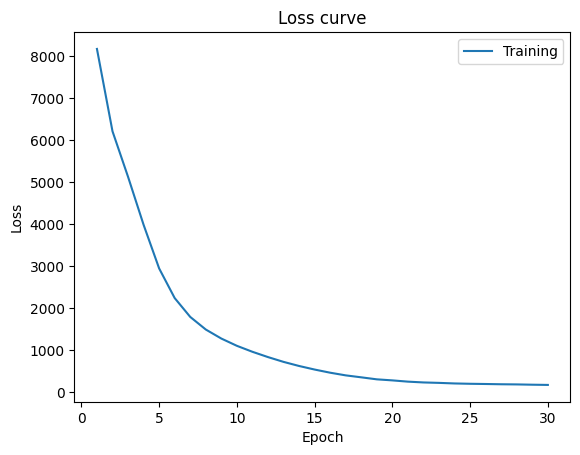

In [222]:
plt.plot(np.arange(1, epochs+1), training_loss, label='Training')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss curve')
plt.show()

In [223]:
def predict_next_word(model, context, word2idx, idx2word):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor([word2idx[word] for word in context], dtype=torch.long).unsqueeze(0)
        output = model(input_tensor)
        predicted_idx = output.argmax(dim=1).item()
        return idx2word[predicted_idx]

# Try it out
context_words = ['this', 'tremendous', '100']
for i in range(100):
    predicted = predict_next_word(model, context_words[-3:], word2idx, idx2word)
    context_words.append(predicted)

# convert a list of strings into one string with spaces between each word
print(' '.join(context_words))


this tremendous 100 % varietal wine hails from oakville and was aged over three years in oak . juicy red-cherry fruit and a compelling hint of caramel greet the palate , followed by acid-driven waves of juniper , pine and bay leaf , finishing with a menthol-like sensation . tannins and dense a it 's got a rich core of butterscotch and the seemingly endless layers of subtle flavors that biodynamic farming can bring . it spends 18 months on the lees prior to bottling . drink now through 2028 . with an blackberry flavors of toast , cigar box , blackberry ,


# Visualize embedding

In [224]:
# get the learned embedding weights from the model
embeddings = model.embedding.weight.detach().numpy()

# there will be one row for each token,
# and columns for the embedding dimensions
embeddings.shape

(554, 10)

(554, 2)


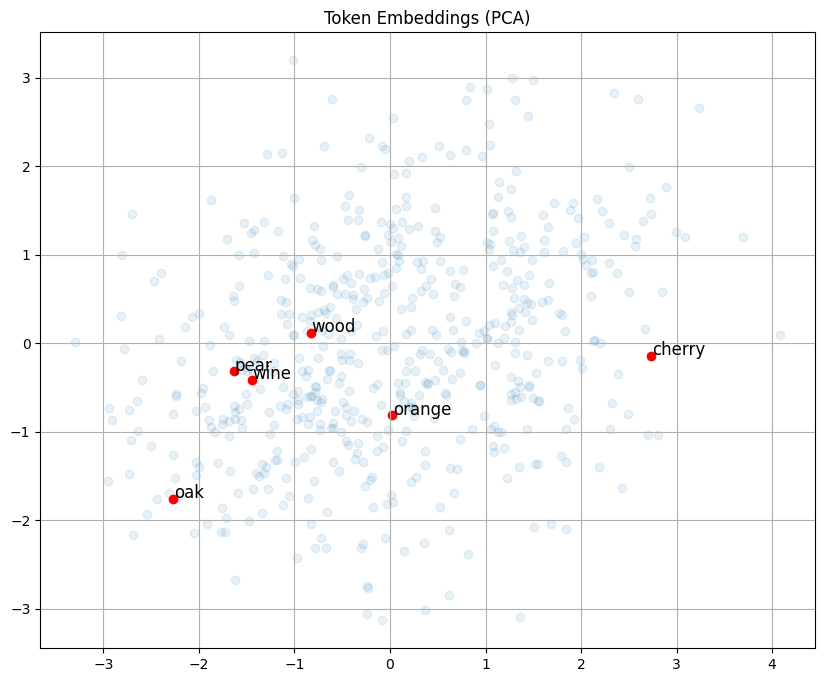

In [225]:
# reduce to 2D for scatter plot
pca = PCA(n_components=2)
pca.fit(embeddings)
embeddings2d = pca.transform(embeddings)
print(embeddings2d.shape)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings2d[:, 0], embeddings[:, 1], alpha=0.1)

# show the text for a few tokens
show_words = ['cherry', 'pear', 'orange',
              'wood', 'oak', 'wine']
for word in show_words:
    idx = word2idx[word]
    x, y = embeddings2d[idx]
    plt.scatter(x, y, c='red')
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)

plt.title("Token Embeddings (PCA)")
plt.grid(True)
plt.show()